# Выбор ключевой метрики на основе модели монетизации

In [101]:
import pandas as pd
import numpy as np

## Модель подписки

### Проверяем данные

In [102]:
data_subscrip = pd.read_csv('customer_product.csv', nrows=100000)

In [103]:
data_subscrip.head()

,Unnamed: 0,customer_id,product,signup_date_time,cancel_date_time
0,1,C2448,prd_1,2017-01-01 10:35:09,NaN
1,2,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02
2,3,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55
3,4,C2451,prd_2,2017-01-01 13:32:08,NaN
4,5,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01


In [104]:
data_subscrip['cancel_date_time'] = pd.to_datetime(data_subscrip['cancel_date_time'])
data_subscrip['signup_date_time'] = pd.to_datetime(data_subscrip['signup_date_time'])

### Метрики

1. Конверсия в подписку — доля новых пользователей, которые оформили подписку.

In [105]:
# def conversion(product_type, month, year):
#     data_subscrip[(data_subscrip['signup_date_time'].dt.month = month) & 
#                   (data_subscrip['signup_date_time'].dt.year = year)].count()

2. Retention (англ. «удержание») — доля подписчиков одного из прошлых месяцев, которые продолжили платить за подписку в текущем месяце.


In [106]:
def retention(product_type, month, year):
    
    currnt_munth_start = pd.Timestamp(year=year, month=month, day=1)

    if (currnt_munth_start > data_subscrip['signup_date_time'].max()) or (currnt_munth_start < data_subscrip['signup_date_time'].min()):
        return np.nan

    if month+1 == 13:
        next_month_start = pd.Timestamp(year=year+1, month=1, day=1)
    else:
        next_month_start = pd.Timestamp(year=year, month=month+1, day=1)

    # активные пользователей в прошлом месяце
    activ_last_month = data_subscrip[(data_subscrip['product'] == product_type) & 
                              
                              # проверям, что оформил подписку не позднее прошлого месяца
                              (data_subscrip['signup_date_time'] < currnt_munth_start) &
                              
                              # проверяем, что завершил подписку не раньше прошлого месяца
                              ((data_subscrip['cancel_date_time'] >= currnt_munth_start) |      
                                (data_subscrip['cancel_date_time'].isna()))]
    

    count_last_month = len(activ_last_month)

    if count_last_month == 0:
        return 0

    # знаем какие пользователи были в продукте в прошлом месяце, ищем какие из них остались в этом 
    activ_new_month = activ_last_month[(activ_last_month['cancel_date_time'] >= next_month_start) |      
                                        (activ_last_month['cancel_date_time'].isna())]
    
    count_new_month = len(activ_new_month)

    # считаем retention
    retention_value = count_new_month/count_last_month           

    return round(retention_value*100, 2)

retention('prd_1', 12, 2020)

98.94

In [107]:
data = pd.DataFrame({
    'month': [],
    'retention': []
})

In [108]:
data['month'] = data_subscrip['signup_date_time'].dt.to_period('M').unique()
data['retention'] = data['month'].apply(lambda x: retention('prd_1', x.month, x.year))

In [109]:
data.shape

(51, 2)

<Axes: xlabel='month'>

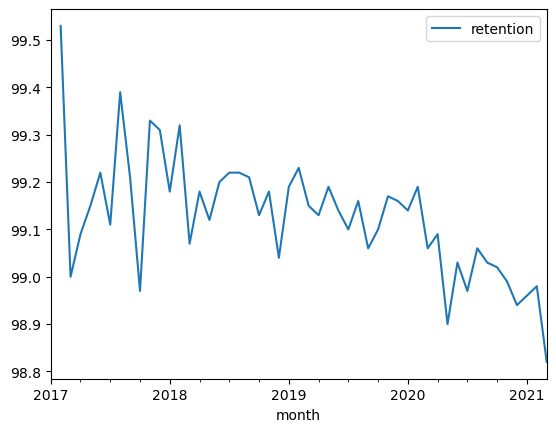

In [110]:
data.plot(kind='line', x='month', y='retention')

## Рекламная модель 

### Проверяем данные 

In [111]:
data_advertising = pd.read_csv('online_advertising_performance_data.csv', nrows=100000)

In [112]:
data_advertising.info(), data_advertising.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15408 entries, 0 to 15407
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   month                    15408 non-null  object 
 1   day                      15408 non-null  int64  
 2   campaign_number          15408 non-null  object 
 3   user_engagement          15408 non-null  object 
 4   banner                   15408 non-null  object 
 5   placement                14995 non-null  object 
 6   displays                 15408 non-null  int64  
 7   cost                     15408 non-null  float64
 8   clicks                   15408 non-null  int64  
 9   revenue                  15408 non-null  float64
 10  post_click_conversions   15408 non-null  int64  
 11  post_click_sales_amount  15408 non-null  float64
 12  Unnamed: 12              0 non-null      float64
 13  Unnamed: 13              0 non-null      float64
dtypes: float64(5), int64(4

(None,
                 day       displays          cost        clicks       revenue  \
 count  15408.000000   15408.000000  15408.000000  15408.000000  15408.000000   
 mean      15.518886   15512.573014     11.370262    161.788487     17.929943   
 std        8.740909   44392.392890     45.369499    728.276911     96.781834   
 min        1.000000       0.000000      0.000000      0.000000      0.000000   
 25%        8.000000      78.000000      0.024000      0.000000      0.000000   
 50%       15.000000    1182.000000      0.339850      6.000000      0.483950   
 75%       23.000000    8960.250000      2.536225     53.000000      3.839800   
 max       31.000000  455986.000000    556.704800  14566.000000   2096.211600   
 
        post_click_conversions  post_click_sales_amount  Unnamed: 12  \
 count            15408.000000             15408.000000          0.0   
 mean                42.300623              2123.288058          NaN   
 std                213.685660             105

In [113]:
data_advertising.head()

,month,day,campaign_number,user_engagement,banner,placement,displays,cost,clicks,revenue,post_click_conversions,post_click_sales_amount,Unnamed: 12,Unnamed: 13
0,April,1,camp 1,High,160 x 600,abc,4,0.0060,0,0.0000,0,0.0000,NaN,NaN
1,April,1,camp 1,High,160 x 600,def,20170,26.7824,158,28.9717,23,1972.4602,NaN,NaN
2,April,1,camp 1,High,160 x 600,ghi,14701,27.6304,158,28.9771,78,2497.2636,NaN,NaN
3,April,1,camp 1,High,160 x 600,mno,171259,216.8750,1796,329.4518,617,24625.3234,NaN,NaN
4,April,1,camp 1,Low,160 x 600,def,552,0.0670,1,0.1834,0,0.0000,NaN,NaN


In [114]:
data_advertising['month'].value_counts()

month
April    6269
May      4705
June     4434
Name: count, dtype: int64

In [115]:
data_advertising['month'] = pd.to_datetime(data_advertising['month'], format='%B').dt.month

def rename_(month, day):
    data = pd.Timestamp(year=2020, month=month, day=day)
    return data

data_advertising['data'] = data_advertising[['month', 'day']].apply(lambda x: rename_(x['month'], x['day']), 
                                                                    axis=1)

In [116]:
data_advertising.head()

,month,day,campaign_number,user_engagement,banner,placement,displays,cost,clicks,revenue,post_click_conversions,post_click_sales_amount,Unnamed: 12,Unnamed: 13,data
0,4,1,camp 1,High,160 x 600,abc,4,0.0060,0,0.0000,0,0.0000,NaN,NaN,2020-04-01
1,4,1,camp 1,High,160 x 600,def,20170,26.7824,158,28.9717,23,1972.4602,NaN,NaN,2020-04-01
2,4,1,camp 1,High,160 x 600,ghi,14701,27.6304,158,28.9771,78,2497.2636,NaN,NaN,2020-04-01
3,4,1,camp 1,High,160 x 600,mno,171259,216.8750,1796,329.4518,617,24625.3234,NaN,NaN,2020-04-01
4,4,1,camp 1,Low,160 x 600,def,552,0.0670,1,0.1834,0,0.0000,NaN,NaN,2020-04-01


### Метрики

1. Средний доход на одного пользователя (ARPU) можно посчитать одним из двух методов в зависимости от того, за что платят рекламодатели.

In [117]:
data_advertising.head(3)

,month,day,campaign_number,user_engagement,banner,placement,displays,cost,clicks,revenue,post_click_conversions,post_click_sales_amount,Unnamed: 12,Unnamed: 13,data
0,4,1,camp 1,High,160 x 600,abc,4,0.0060,0,0.0000,0,0.0000,NaN,NaN,2020-04-01
1,4,1,camp 1,High,160 x 600,def,20170,26.7824,158,28.9717,23,1972.4602,NaN,NaN,2020-04-01
2,4,1,camp 1,High,160 x 600,ghi,14701,27.6304,158,28.9771,78,2497.2636,NaN,NaN,2020-04-01


* Когда платят за показы:

*CPI (англ. cost per impression) — это стоимость одного показа рекламы. Часто встречается показатель CPM (англ. cost per mile) — стоимость 1000 показов.*

* Когда платят за клики:

*CTR (англ. click-through rate) — это отношение числа целевых действий к показам.*

*CPA (англ. cost per action) — плата за целевое действие: клик, регистрацию, покупку или что-то ещё.*

## Транзакционная модель 

### Проверяем данные

### Метрики

1. **ARPU** (англ. average revenue per user) — средний доход с одного клиента.


2. **Gross merchandise volume (GMV)** — общий объём продаж через платформу за период времени.


3. **Gross transaction value (GTV)** — сумма полученных платформой комиссий с транзакций.

Сложно принимать решения на основе GMV и GTV, поскольку они не берут в расчёт число пользователей и непонятно, почему они растут или падают.

## Метрики, важные для всех типов монетизации